In [1]:
import torch
import math 
import matplotlib.pyplot as plt 

# 1 Generate data set 

In [32]:
def generate_disc_set(nb):
    """
    Parameters
    ----------
    nb : int
         number of samples

    Returns
    -------
    inp : torch.float32
          dimensions nbx2
          input of a toy dataset
          uniformly distributed in [-1,1]x[-1,1]

    target : torch.int64
             dimensions nb
             label is 1 inside disc of radius sqrt(2/pi) and 0 outside
    """
    baseline = math.sqrt(2/math.pi)
    inp = torch.FloatTensor(nb, 2).uniform_(-1, 1)

    l2norm = torch.sqrt(torch.pow(inp, 2).sum(1))
        
    target = torch.zeros(l2norm.shape[0])
    target[l2norm < baseline] = 1
    return inp, target.long()

In [33]:
def normalise(train_inp, test_inp):
    # normalise inp tensor to have mean 0 and var 1
    mu, std = train_inp.mean(), train_inp.std()
    train_inp.sub_(mu).div_(std)
    test_inp.sub_(mu).div_(std)
    return train_inp, test_inp

In [66]:
nb = 1000
train_inp, train_target = generate_disc_set(nb)

In [67]:
train_inp.shape

torch.Size([1000, 2])

In [68]:
train_target.shape

torch.Size([1000])

In [69]:
train_inp.var()

tensor(0.3388)

In [70]:
test_inp, test_target = generate_disc_set(nb)

## Check the classes are balanced 

In [73]:
torch.bincount(train_target)

tensor([502, 498])

In [74]:
torch.bincount(test_target)

tensor([505, 495])

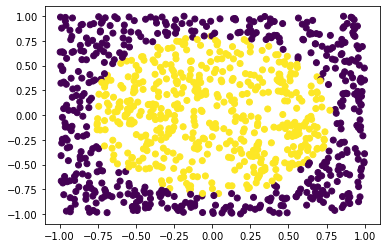

In [77]:
plt.scatter(train_inp[:,0], train_inp[:,1], c=train_target)

We can see that the points are uniformly distributed.

## Normalise data

In [78]:
# normalise mean and variance to 0 and 1
train_inp, test_inp = normalise(train_inp, test_inp)

In [72]:
train_inp.var()

In [79]:
train_inp.shape

torch.Size([1000, 2])

In [80]:
train_target.shape

torch.Size([1000])

In [81]:
test_inp.shape

torch.Size([1000, 2])

In [82]:
test_target.shape

torch.Size([1000])

# 2 Train and test

In [204]:
from torch import nn
from torch.nn import functional as F

In [205]:
def train_model(model, train_input, train_target):
    # train model with cross entropy 
    # 250 epochs of standard SGD with eta = 0.1, minibatches of 100 
    nb_epochs = 250
    eta = 0.1
    batch_size = 100 
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    criterion = nn.CrossEntropyLoss()
    
    for e in range(nb_epochs):
        for inp, targets in zip(train_input.split(batch_size),
                               train_target.split(batch_size)):
            output = model(inp)
            loss = criterion(output, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model 

In [206]:
def compute_nb_errors(model, data_inputs, data_targets, batch_size=100):
    # count incorrect
    count = 0
    for mb_idx, (inp, targets) in enumerate(zip(data_inputs.split(batch_size), 
                           data_targets.split(batch_size))):
        start_idx = mb_idx * batch_size
        end_idx = start_idx + batch_size
        output = model(inp)
        pred_labels = torch.argmax(output, dim=1)
        true_labels = data_targets[start_idx:end_idx]
        
        count += torch.count_nonzero(true_labels - pred_labels)

    # get error % 
    score = 100 * count / data_targets.size(0)
    return score

In [207]:
def get_train_test_error(model, train_inp, train_target,
                        test_inp, test_target):
    train_score = compute_nb_errors(model, train_inp, train_target)
    print('train error of {} %'.format(train_score))
    test_score = compute_nb_errors(model, test_inp, test_target)
    print('test error of {} %'.format(test_score))
    return train_score, test_score

# 3 Define models

In [257]:
def fix_init_stdev(model, init_stdev):
    for i, operation in enumerate(model):
        if type(operation) == nn.Linear:
            with torch.no_grad():
                model[i].bias.data.normal_(0., init_stdev)
                model[i].weight.data.normal_(0., init_stdev)
        
    return model 

In [251]:
def create_shallow_model(init_stdev=None):
    model = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )
    
    if init_stdev: 
        model = fix_init_stdev(model, init_stdev)
    return model 

In [263]:
def create_deep_model(init_stdev=None):
    model = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,8),
            nn.ReLU(),
            nn.Linear(8,16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
    )
    
    if init_stdev: 
        model = fix_init_stdev(model, init_stdev)
    return model

## Train shallow model (default)

In [266]:
def train_test_shallow_model(train_inp, train_target, test_inp, test_target,
                            init_stdev=None):
    shallow = create_shallow_model(init_stdev=init_stdev)
    model = train_model(shallow, train_inp, train_target)
    train_error, test_error = get_train_test_error(model, 
                                                  train_inp, train_target,
                                                  test_inp, test_target)
    return train_error, test_error

In [267]:
tr_err, te_err = train_test_shallow_model(train_inp, train_target, 
                                          test_inp, test_target)

train error of 0.800000011920929 %
test error of 0.699999988079071 %


## Train deep model 

In [268]:
def train_test_deep_model(train_inp, train_target, test_inp, test_target,
                         init_stdev=None):
    deep = create_deep_model(init_stdev=init_stdev)
    model = train_model(deep, train_inp, train_target)
    train_error, test_error = get_train_test_error(model, 
                                                  train_inp, train_target,
                                                  test_inp, test_target)
    return train_error, test_error

In [269]:
tr_err, te_err = train_test_deep_model(train_inp, train_target,
                                      test_inp, test_target)

train error of 1.0 %
test error of 1.7000000476837158 %


# 4 Benchmarking
Compute train/test errors of two models when they are initialised with:
- Pytorch default 
- Normal distribution w stdev 1e-3, 1e-2, 1e-1, 1, 10

Error rate with shallow network should be around 1.5%, and around 3% for deep network with default, and around 50% of the time otherwise

In [281]:
init_stdev_list = [None, 1e-3, 1e-2, 1e-1, 10]
deep_model_tr_errors = []
deep_model_te_errors = []
shallow_model_tr_errors = []
shallow_model_te_errors = []

for stdev in init_stdev_list: 
    d_tr_err, d_te_err = train_test_deep_model(train_inp, train_target,
                                              test_inp, test_target,
                                              init_stdev=stdev)
    deep_model_tr_errors.append(d_tr_err)
    deep_model_te_errors.append(d_te_err)
    
    s_tr_err, s_te_err = train_test_shallow_model(train_inp, train_target,
                                              test_inp, test_target,
                                              init_stdev=stdev)
    shallow_model_tr_errors.append(s_tr_err)
    shallow_model_te_errors.append(s_te_err)

train error of 1.5 %
test error of 1.600000023841858 %
train error of 0.4000000059604645 %
test error of 0.699999988079071 %
train error of 49.79999923706055 %
test error of 49.5 %
train error of 1.2000000476837158 %
test error of 2.0 %
train error of 49.79999923706055 %
test error of 49.5 %
train error of 0.5 %
test error of 0.5 %
train error of 49.79999923706055 %
test error of 49.5 %
train error of 0.4000000059604645 %
test error of 0.699999988079071 %
train error of 49.79999923706055 %
test error of 49.5 %
train error of 0.4000000059604645 %
test error of 1.0 %


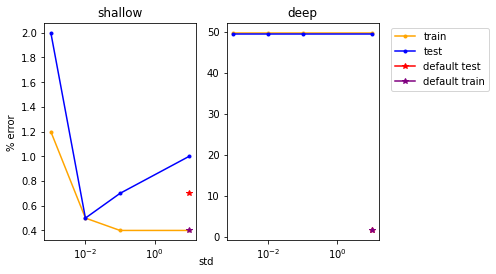

In [287]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(init_stdev_list[1:], shallow_model_tr_errors[1:], marker=".", color="orange", label="train")
ax[0].plot(init_stdev_list[1:], shallow_model_te_errors[1:], marker=".", color="blue", label="test")
ax[0].plot(init_stdev_list[-1], shallow_model_te_errors[0], marker="*", color="red", label="default test")
ax[0].plot(init_stdev_list[-1], shallow_model_tr_errors[0], marker="*", color="purple", label="default train")
ax[0].set_title("shallow")
ax[1].plot(init_stdev_list[1:], deep_model_tr_errors[1:], marker=".", color="orange", label="train")
ax[1].plot(init_stdev_list[1:], deep_model_te_errors[1:], marker=".", color="blue", label="test")
ax[1].plot(init_stdev_list[-1], deep_model_te_errors[0], marker="*", color="red", label="default test")
ax[1].plot(init_stdev_list[-1], deep_model_tr_errors[0], marker="*", color="purple", label="default train")
ax[1].set_title("deep")
fig.text(0.5, 0.04, "std", ha="center")
fig.text(0.04, 0.5, "% error", va="center", rotation="vertical")
for a in ax: 
    a.set_xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")